# Домашнее задание 5. Линейные модели

In [1]:
import random as pr
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import sklearn.cross_validation as cv
import sklearn.metrics as sm
#import numdifftools as nd

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Зачитываем результат 4 домашки

In [3]:
data = np.load("out_4_dat.npz")
users = data["users"]
X_dataset = data["data"].reshape(1,)[0]

Зачитываем категории пользователей

In [4]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0)
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0)
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

Модель строим для пользователей из twitter_train, нужно выбрать этих пользователей из матрицы из 4 ДЗ:

In [6]:
# TODO check this code
train_users = df_users_train["uid"].values
ix = np.in1d(users, train_users).reshape(users.shape)
X = X_dataset[np.where(ix)]
#X_res = X_mini[np.where(ix==False)]

In [7]:
X.shape

(5000, 154179)

Формируем целевую переменную: Делаем join списка пользователей из ДЗ4 с обучающей выборкой.

In [8]:
Y = df_users_train['cat'].values
print "Resulting training set: (%dx%d) feature matrix, %d target vector" % (X.shape[0], X.shape[1], Y.shape[0])

Resulting training set: (5000x154179) feature matrix, 5000 target vector


Чтобы исследовать, как ведут себя признаки, построим распределение количества ненулевых признаков у пользователей, чтобы убедиться, что он удовлетворяет закону Ципфа. Для этого построим гистограмму в логарифмических осях. [Подсказка](http://anokhin.github.io/img/sf1.png)

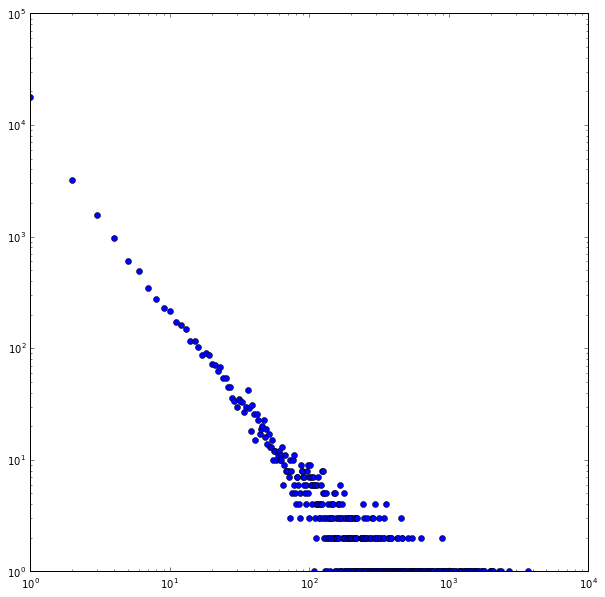

In [11]:
def draw_log_hist(x):
    """Draw tokens histogram in log scales"""
    feature_counts = np.asarray(x.astype(bool).sum(axis=0))[0]
    feature_user_counts = np.bincount(feature_counts)[1:]
    user_counts = np.arange(1, len(feature_user_counts) + 1)
    pl.figure(figsize=(10,10))
    pl.plot(user_counts, feature_user_counts, 'bo')

    pl.xscale("log")
    pl.yscale("log")
    return feature_counts
    
    return [0] * x.shape[1]

features_counts = draw_log_hist(X)

Проведем отбор признаков. В самом простом случае просто удаляем признаки, имеющие ненулевое значение у менее, чем 100 пользователей.

In [12]:
X1 = X.tocsc()[:, features_counts > 100].toarray()

In [13]:
X1.shape

(5000L, 620L)

Вариант задания генерируется на основании вашего ника в техносфере.

In [14]:
USER_NAME = "p.olshevskaya"
OPTIMIZATION_ALGORITHMS = ["stochastic gradient descent", "Newton method"]
REGULARIZATIONS = ["L1", "L2"]

print "My homework 5 algorithm is: Logistic regression with %s regularization optimized by %s" % (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    OPTIMIZATION_ALGORITHMS[hash(USER_NAME[::-1]) % 2]
)

My homework 5 algorithm is: Logistic regression with L2 regularization optimized by Newton method


Реализуем выбранный алгоритм

In [32]:
class LogisticRegression():
    def __init__(self, C=1, eps=0.001, max_iter = 10000):
        self.C = C
        self.eps = eps
        self.max_iter = max_iter
        
    def fit(self, X, Y=None):
        b_prev = np.zeros(len(X[1]) + 1)
        self.b = np.zeros(len(X[1]) + 1)
        self.b[0] = log(np.mean(Y) / (1 - np.mean(Y)))
        X = np.insert(X, 0, values=1, axis=1)
        it = 0
        diff = +inf
        
        while diff > self.eps and it < self.max_iter:
            z = np.dot(X, self.b)
            p = np.clip(1.0 / (1 + exp(-z)), 0.000000000000001, 0.9999999999999) 
            w = p*(1-p) 
            u = z+(Y-p)/w 
            W = np.diag(w) 
            E = np.diag(np.ones(len(X[0])))
            E[0][0] = 0
            b_prev = self.b
            
            #b = (X.T*W*X + C*E)^-1 * X.T*W*u
            T = np.dot(np.dot(X.T, W), X)
            T += self.C*E
            T = np.linalg.inv(T)
            T = np.dot(np.dot(T, X.T), W)
            T = np.dot(T, u)
            self.b = T
            diff = np.sum((b_prev-self.b)**2)
            it += 1
        return self
    
    def predict_proba(self, X):
        X = np.insert(X, 0, values=1, axis=1)
        z = np.dot(X, self.b)
        return np.clip(1.0 / (1 + exp(-z)), 0.000000000000001, 0.9999999999999)

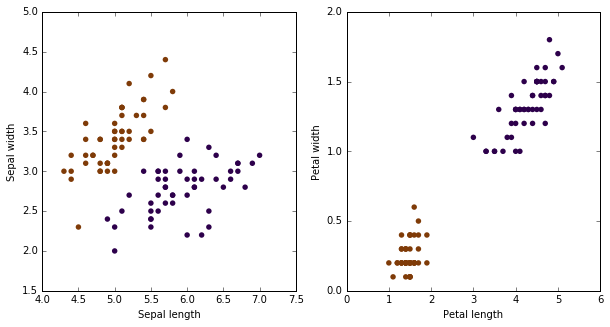

In [16]:
import sklearn.datasets as ds
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [34]:
logreg = LogisticRegression(C = 0.1)

In [35]:
logreg.fit(X=x_iris, Y = y_iris)

<__main__.LogisticRegression instance at 0x000000000BD2DF08>

In [21]:
aaa = logreg.predict_proba(X=x_iris)

In [24]:
import sklearn.metrics

Реализуем метрику качества, используемую в соревновании: площадь под ROC кривой

In [30]:
def auroc(y_prob, y_true):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_prob, pos_label=1)
    return sklearn.metrics.auc(fpr, tpr)

In [31]:
auroc(aaa,y_iris)

1.0

In [37]:
import sklearn.cross_validation

Разделим выборку с помощью методики кросс-валидации для того, чтобы настроить параметр регуляризации $C$

In [56]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]

def select_reg_parameter(C, X, Y, k):
    
    split = sklearn.cross_validation.KFold(len(X),shuffle=True, n_folds=k)
    auc = []
    for c in C:
        
        score_arr = np.zeros(5)
        k = 0
        for train_index, test_index in split:
            logreg = LogisticRegression(C = c)
            logreg.fit(X=X[train_index],Y=Y[train_index])
            pred = logreg.predict_proba(X=X[test_index])
            score = auroc(pred,Y[test_index])
            score_arr[k] = score
            k+=1
        print ('c = %f ' % c + 'auroc = %f' % score_arr.mean())
        auc.append(score_arr.mean())
    return auc.index(max(auc))




index = select_reg_parameter(C, X1, Y,5)


c = 0.000100 auroc = 0.598066
c = 0.001000 auroc = 0.598066
c = 0.010000 auroc = 0.598074
c = 0.100000 auroc = 0.598148
c = 1.000000 auroc = 0.598783
c = 10.000000 auroc = 0.602215
c = 100.000000 auroc = 0.620472
c = 1000.000000 auroc = 0.644285
c = 10000.000000 auroc = 0.655014
c = 100000.000000 auroc = 0.652314
c = 1000000.000000 auroc = 0.636233


In [57]:
print(index)

8


Выбираем наилучшее значение $C$, и классифицируем неизвестных пользователей и строим ROC-кривую

Area under the ROC curve : 0.645941


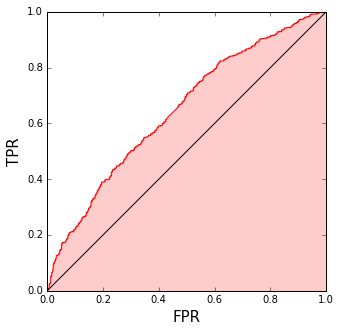

In [59]:
def classify(X, Y, test_size, C):
    
    x_train, x_test, y_train, y_test = cv.train_test_split(X, Y, test_size=test_size)
    logreg = LogisticRegression(C = C)
    logreg.fit(x_train,y_train)
    pred = logreg.predict_proba(x_test)
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, pred, pos_label=1)
    roc_auc = auroc(pred,y_test)
    
    return tpr, fpr, roc_auc

tpr, fpr, roc_auc = classify(X1, Y, 0.3, C[index])

print "Area under the ROC curve : %f" % roc_auc

def plot_roc_curve(tpr, fpr, roc_auc):
    """Plot ROC curve"""
    fig = plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='red')
    plt.plot([0, 1], [0, 1], color='black')
    plt.fill_between(fpr, tpr, alpha=0.2, color='red')
    plt.xlabel("FPR", fontsize=15)
    plt.ylabel("TPR", fontsize=15)
    plt.show()
    return


plot_roc_curve(tpr, fpr, roc_auc)

С помощью полученной модели предсказываем категории для неизвестных пользователей из соревнования и загружаем на kaggle в нужном формате. ДЗ принимается только при наличии загруженных данных на kaggle.